Figure 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, activation_func='sigmoid'):
        super(NeuralNetwork, self).__init__()
        self.first = nn.Linear(input_dim, 100)
        self.hidden1 = nn.Linear(100, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)
        if activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.first(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        return self.output(x)

# HOVR regularization
def hovr_regularization(model, x, k=3, q=2, M=10):
    x_min, x_max = x.min(0)[0], x.max(0)[0]
    random_points = torch.tensor(
        np.random.uniform(x_min.cpu().detach().numpy(), x_max.cpu().detach().numpy(), (M, x.shape[1])),
        dtype=torch.float32, requires_grad=True).to(device)
    preds = model(random_points)
    grads = torch.autograd.grad(preds, random_points, torch.ones_like(preds),
                                create_graph=True)[0]
    hovr_term = 0.0
    n_dims = x.shape[1]
    for i in range(n_dims):
        grad_i = grads[:, i]
        temp_grad = grad_i
        for _ in range(k - 1):
            temp_grad = torch.autograd.grad(temp_grad, random_points,
                                            torch.ones_like(temp_grad),
                                            create_graph=True)[0][:, i]
        hovr_term += (1 / n_dims) * torch.sum(torch.abs(temp_grad) ** q)
    return hovr_term

# Transformed TTL + HOVR loss function
def transformed_ttl_hovr_loss(model, xi, x, y, h, lambd, k, q):
    n = x.shape[0]
    preds = model(x)
    residuals = (y - preds).view(-1, 1)
    # Loss function computation
    loss_fit = (1 / n) * torch.sum((residuals - xi) ** 2)
    # T_h(ξ) computation
    xi_squared = xi.view(-1) ** 2
    T_h_xi = (1 / n) * torch.sum(torch.topk(xi_squared, h, largest=False)[0])
    # HOVR term computation
    hovr_term = lambd * hovr_regularization(model, x, k, q)
    # Total loss
    total_loss = loss_fit + T_h_xi + hovr_term
    return total_loss

# Data generation function
def generate_data(n=100, noise_std=0.2, outlier_ratio=0.03):
    x1 = np.linspace(0, 2 * np.pi, int(np.sqrt(n)))
    x2 = np.linspace(0, 2 * np.pi, int(np.sqrt(n)))
    x1_grid, x2_grid = np.meshgrid(x1, x2)
    X = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T
    y_true = np.sin(2 * X[:, 0]) * np.cos(2 * X[:, 1])
    y = y_true + np.random.normal(0, noise_std, X.shape[0])

    # Insert outliers
    n_outliers = int(n * outlier_ratio)
    outlier_indices = np.random.choice(n, n_outliers, replace=False)
    y[outlier_indices] = 5 + np.random.uniform(-0.1, 0.1, n_outliers)

    return X, y, y_true, outlier_indices

# Main experiment
def run_experiment(use_hovr=True):
    # Generate data
    X, y, y_true, outlier_indices = generate_data()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)

    # Initialize model and optimizer
    model = NeuralNetwork().to(device)
    n_params = X.shape[0]
    xi = nn.Parameter(torch.zeros(n_params, 1, dtype=torch.float32).to(device))
    optimizer = optim.Adam(list(model.parameters()) + [xi], lr=0.01)
    h = int(0.9 * n_params)  # Trimming factor
    lambd = 1e-3
    k = 2
    q = 2
    epochs = 5000

    # Track training time
    hovr_times = []
    ttl_times = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        start_time = time.time()
        loss = transformed_ttl_hovr_loss(model, xi, X_tensor, y_tensor, h, lambd, k, q)
        hovr_times.append(time.time() - start_time) if use_hovr else ttl_times.append(time.time() - start_time)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6f}")

    return hovr_times if use_hovr else ttl_times

# Plot cumulative times
def plot_times(hovr_times, ttl_times):
    plt.figure(figsize=(10, 6))
    # Cumulative time for TTL+HOVR
    for trial in hovr_times:
        plt.plot(np.cumsum(trial), color='blue', label='TTL+HOVR' if trial == hovr_times[0] else "")

    # Cumulative time for TTL only
    for trial in ttl_times:
        plt.plot(np.cumsum(trial), color='green', label='TTL only' if trial == ttl_times[0] else "")

    plt.xlabel("Iteration")
    plt.ylabel("Computational Time (seconds)")
    plt.title("TTL vs TTL+HOVR Computational Time")
    plt.legend()
    plt.show()

# Run multiple experiments
hovr_all_times = []
ttl_all_times = []
for trial in range(10):
    print(f"Running trial {trial + 1} with TTL+HOVR...")
    hovr_times = run_experiment(use_hovr=True)
    hovr_all_times.append(hovr_times)

    print(f"Running trial {trial + 1} with TTL only...")
    ttl_times = run_experiment(use_hovr=False)
    ttl_all_times.append(ttl_times)

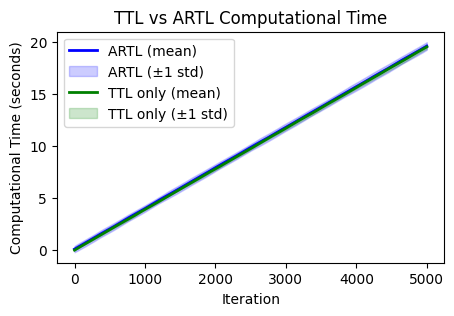

In [ ]:
import numpy as np

def plot_times_with_error(hovr_times, ttl_times):
    plt.figure(figsize=(5, 3))

    # TTL+HOVR
    hovr_times_np = np.array([np.cumsum(trial) for trial in hovr_times])
    hovr_mean = np.mean(hovr_times_np, axis=0)
    hovr_std = np.std(hovr_times_np, axis=0)

    # TTL only
    ttl_times_np = np.array([np.cumsum(trial) for trial in ttl_times])
    ttl_mean = np.mean(ttl_times_np, axis=0)
    ttl_std = np.std(ttl_times_np, axis=0)

    # Plot (TTL+HOVR)
    plt.plot(hovr_mean, color='blue', label='ARTL (mean)', lw=2)
    plt.fill_between(range(len(hovr_mean)), hovr_mean - hovr_std, hovr_mean + hovr_std, color='blue', alpha=0.2, label='ARTL (±1 std)')

    # Plot (TTL only)
    plt.plot(ttl_mean, color='green', label='TTL only (mean)', lw=2)
    plt.fill_between(range(len(ttl_mean)), ttl_mean - ttl_std, ttl_mean + ttl_std, color='green', alpha=0.2, label='TTL only (±1 std)')

    plt.xlabel("Iteration")
    plt.ylabel("Computational Time (seconds)")
    plt.title("TTL vs ARTL Computational Time")
    plt.legend()
    plt.show()

plot_times_with_error(hovr_all_times, ttl_all_times)

In [ ]:
import numpy as np

def print_cumulative_total_time(hovr_all_times, ttl_all_times):
    hovr_times = np.array(hovr_all_times)
    ttl_times = np.array(ttl_all_times)

    hovr_avg_time = np.mean(hovr_times, axis=0)
    ttl_avg_time = np.mean(ttl_times, axis=0)

    hovr_total_time = np.sum(hovr_avg_time)
    ttl_total_time = np.sum(ttl_avg_time)

    print(f"Total Cumulative Time (TTL+HOVR): {hovr_total_time:.4f} sec")
    print(f"Total Cumulative Time (TTL only): {ttl_total_time:.4f} sec")

print_cumulative_total_time(hovr_all_times, ttl_all_times)

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}, Total Memory: {gpu_info.total_memory / 1e9:.2f} GB")

[0.10466354 0.00416975 0.00427644 ... 0.00383735 0.00378513 0.00388503]
Total Cumulative Time (TTL+HOVR): 19.5975 sec
Total Cumulative Time (TTL only): 19.5154 sec
